In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/combined1_hNIL")

In [0]:
# required for umap clustering
! pip3 install leidenalg 
! pip3 install scanpy
# ! pip install python-igraph
# ! pip install louvain
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt


In [60]:
sc.settings.verbosity = 3 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.3 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.0


# Load the single cell object

In [62]:
# get the h5ad resulting from scanpy analysis
%ls scanpy_out/

combined1_hNIL_before_neighbors.h5ad  top_markers_combined1_hNIL.csv
combined1_hNIL.h5ad


In [0]:
# load the scanpy object which has been analyzed before
adata = sc.read("scanpy_out/combined1_hNIL.h5ad")

In [65]:
adata

AnnData object with n_obs × n_vars = 6038 × 2183 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

# Add my donor information from vireo_out

Note that here we use 7 donors because GT19-38452 and GT19-38451 are the same donor.

In [63]:
# get the genotyping infomation after cellSNP_vireo analysis
%ls vireo/vireo_out/

donor_ids.tsv                  _log.txt             prob_singlet.tsv.gz
fig_GT_distance_estimated.pdf  prob_doublet.tsv.gz  summary.tsv


In [90]:
# the cell barcode has been annotated using the donor_id by vireo
donors= pd.read_csv("vireo/vireo_out/donor_ids.tsv", '\t', index_col="cell")
donors = donors[["donor_id"]]
#add the column of "donor_label" for match donor_id to donor_label
donors["donor_label"] = donors["donor_id"]
donors.head(4)

,donor_id,donor_label
cell,,
AAACCCAAGCTATCTG-1,doublet,doublet
AAACCCACAAATGCTC-1,GT19-38449,GT19-38449
AAACCCACAGCTTCGG-1,GT19-38447,GT19-38447
AAACCCACAGGTCTCG-1,doublet,doublet


In [91]:
donors.donor_id.value_counts()

GT19-38451    1612
GT19-38447    1378
GT19-38448     858
GT19-38445     832
GT19-38449     508
GT19-38450     379
doublet        332
GT19-38446     297
unassigned       6
Name: donor_id, dtype: int64

# get the metadata of the donors

In [0]:
%ls ../test_vireo/modify_donor/

'Copy of 19-Cel-005 Metadata.xlsx'   test_donor_to_use.vcf.gz
 meta_7Labels.csv                    test_donor.vcf
 meta_wgs_Psomagen.7Labels.csv       test_donor.vcf.gz
 meta_wgs_Psomagen.csv               test_donor.vcf.gz.tbi
 sedfnjT29                           test_today/
 sub_UNHS_changed.vcf.gz             UNHS_to_use_7s.vcf.gz
 sub_UNHS_changed.vcf.gz.tbi         UNHS_to_use.vcf.gz
 sub_UNHS_filter.vcf.gz              UNHS.vcf.gz
 sub_UNHS.vcf.gz                     UNHS.vcf.gz.csi
 sub_UNHS.vcf.gz.csi                 UNHS.vcf.gz.tbi
 test_cell.vcf.gz


In [92]:
# retrieve the 8 donor's original labels from metadata
meta = pd.read_csv("../test_vireo/modify_donor/meta_7Labels.csv")
meta=meta.loc[:, ["sample_id", "donor_label"]]
meta

,sample_id,donor_label
0,GT19-38445,KOLF2-ARID2-A02
1,GT19-38446,KUCG3-C1
2,GT19-38447,NCRM1-C6
3,GT19-38448,NCRM5-C5
4,GT19-38449,PGP1-C2
5,GT19-38450,LNGPI1-C1
6,GT19-38451,NN0003932-C3 or NN0004297-C1


# match donor_id to donor_label

In [0]:
# # match donor_id to donor_label
vals_to_replace = {'GT19-38445':'KOLF2-ARID2-A02', 
                   'GT19-38446':'KUCG3-C1', 
                   'GT19-38447':'NCRM1-C6',
                   'GT19-38448':'NCRM5-C5',
                   'GT19-38449':'PGP1-C2',
                   'GT19-38450':'LNGPI1-C1',
                   'GT19-38451':'NN0003932-C3 or NN0004297-C1',
                   'doublet': 'Doublet'
                   }

donors["donor_label"] = donors["donor_label"].map(vals_to_replace)

In [95]:
donors.head()

,donor_id,donor_label
cell,,
AAACCCAAGCTATCTG-1,doublet,Doublet
AAACCCACAAATGCTC-1,GT19-38449,PGP1-C2
AAACCCACAGCTTCGG-1,GT19-38447,NCRM1-C6
AAACCCACAGGTCTCG-1,doublet,Doublet
AAACCCAGTACTAGCT-1,doublet,Doublet


In [98]:
adata.obs.head()

,n_genes,percent_mito,n_counts,leiden
AAACCCAAGCTATCTG-1,2284,0.070539,4820.0,0
AAACCCACAAATGCTC-1,1820,0.039118,3630.0,3
AAACCCACAGCTTCGG-1,930,0.043135,1646.0,8
AAACCCACAGGTCTCG-1,3396,0.064916,8796.0,12
AAACCCAGTACTAGCT-1,2681,0.058460,5337.0,4


In [99]:
# note that the row numbers of donor_subset and that of adata are not the same because adata has been filtered for doublets
print("cell numbers in donor_file are:", len(donors))
print("cell numbers in adata are:", len(adata.obs))

cell numbers in donor_file are: 6202
cell numbers in adata are: 6038


# merge donor_label to adata

In [100]:
# merge two dataframes
adata.obs = adata.obs.merge(donors, left_index=True, right_index=True)
adata.obs.head()

,n_genes,percent_mito,n_counts,leiden,donor_id,donor_label
AAACCCAAGCTATCTG-1,2284,0.070539,4820.0,0,doublet,Doublet
AAACCCACAAATGCTC-1,1820,0.039118,3630.0,3,GT19-38449,PGP1-C2
AAACCCACAGCTTCGG-1,930,0.043135,1646.0,8,GT19-38447,NCRM1-C6
AAACCCACAGGTCTCG-1,3396,0.064916,8796.0,12,doublet,Doublet
AAACCCAGTACTAGCT-1,2681,0.058460,5337.0,4,doublet,Doublet


In [0]:
adata.obs.to_csv("scanpy_out/combined2_hNIL_adata_with_donors.csv")

# Export tables showing the matching frequences between clusters vs donor 


In [104]:
table = adata.obs.groupby(['donor_label'])['leiden'].agg(["count", "nunique", "unique"])
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
table

,count,nunique,unique
donor_label,,,
Doublet,325,15,"[0, 12, 4, 2, 10, ..., 8, 7, 9, 13, 14] Length: 15 Categories (15, object): [0, 12, 4, 2, ..., 7, 9, 13, 14]"
KOLF2-ARID2-A02,811,15,"[2, 4, 1, 5, 6, ..., 9, 8, 12, 13, 10] Length: 15 Categories (15, object): [2, 4, 1, 5, ..., 8, 12, 13, 10]"
KUCG3-C1,291,13,"[11, 3, 0, 5, 7, ..., 6, 8, 10, 4, 9] Length: 13 Categories (13, object): [11, 3, 0, 5, ..., 8, 10, 4, 9]"
LNGPI1-C1,361,14,"[5, 13, 12, 8, 4, ..., 3, 1, 7, 0, 6] Length: 14 Categories (14, object): [5, 13, 12, 8, ..., 1, 7, 0, 6]"
NCRM1-C6,1337,15,"[8, 10, 0, 3, 2, ..., 6, 4, 12, 7, 14] Length: 15 Categories (15, object): [8, 10, 0, 3, ..., 4, 12, 7, 14]"
NCRM5-C5,835,15,"[3, 11, 1, 8, 2, ..., 10, 9, 6, 13, 14] Length: 15 Categories (15, object): [3, 11, 1, 8, ..., 9, 6, 13, 14]"
NN0003932-C3 or NN0004297-C1,1579,15,"[11, 6, 3, 0, 1, ..., 12, 9, 4, 13, 14] Length: 15 Categories (15, object): [11, 6, 3, 0, ..., 9, 4, 13, 14]"
PGP1-C2,493,13,"[3, 2, 4, 0, 6, ..., 13, 5, 7, 14, 10] Length: 13 Categories (13, object): [3, 2, 4, 0, ..., 5, 7, 14, 10]"


In [0]:
table.to_csv("scanpy_out/combined1_hNIL_donor_by_leiden.csv")

In [105]:
table2 = adata.obs.groupby(['leiden'])['donor_label'].agg(["count", "nunique", "unique"])
table2

,count,nunique,unique
leiden,,,
0,883,8,"[Doublet, NN0003932-C3 or NN0004297-C1, NCRM1-C6, NCRM5-C5, PGP1-C2, KUCG3-C1, KOLF2-ARID2-A02, LNGPI1-C1]"
1,735,8,"[NCRM5-C5, NN0003932-C3 or NN0004297-C1, KOLF2-ARID2-A02, NCRM1-C6, Doublet, PGP1-C2, KUCG3-C1, LNGPI1-C1]"
2,678,8,"[PGP1-C2, Doublet, KOLF2-ARID2-A02, NN0003932-C3 or NN0004297-C1, NCRM5-C5, NCRM1-C6, LNGPI1-C1, KUCG3-C1]"
3,606,8,"[PGP1-C2, NCRM5-C5, NN0003932-C3 or NN0004297-C1, NCRM1-C6, KUCG3-C1, KOLF2-ARID2-A02, Doublet, LNGPI1-C1]"
4,540,8,"[Doublet, KOLF2-ARID2-A02, PGP1-C2, NCRM5-C5, NCRM1-C6, LNGPI1-C1, NN0003932-C3 or NN0004297-C1, KUCG3-C1, nan]"
5,477,8,"[LNGPI1-C1, NN0003932-C3 or NN0004297-C1, KOLF2-ARID2-A02, NCRM1-C6, NCRM5-C5, Doublet, KUCG3-C1, PGP1-C2]"
6,433,8,"[NN0003932-C3 or NN0004297-C1, Doublet, KOLF2-ARID2-A02, PGP1-C2, NCRM1-C6, NCRM5-C5, KUCG3-C1, LNGPI1-C1, nan]"
7,352,8,"[NN0003932-C3 or NN0004297-C1, NCRM5-C5, KUCG3-C1, KOLF2-ARID2-A02, NCRM1-C6, PGP1-C2, Doublet, LNGPI1-C1, nan]"
8,303,7,"[NCRM1-C6, NCRM5-C5, NN0003932-C3 or NN0004297-C1, LNGPI1-C1, KOLF2-ARID2-A02, KUCG3-C1, Doublet]"


In [106]:
table2.to_csv("scanpy_out/combined1_hNIL_leiden_by_donor.csv")
adata.write_h5ad("scanpy_out/combined1_hNIL_with_donors.h5ad")

... storing 'donor_id' as categorical
... storing 'donor_label' as categorical


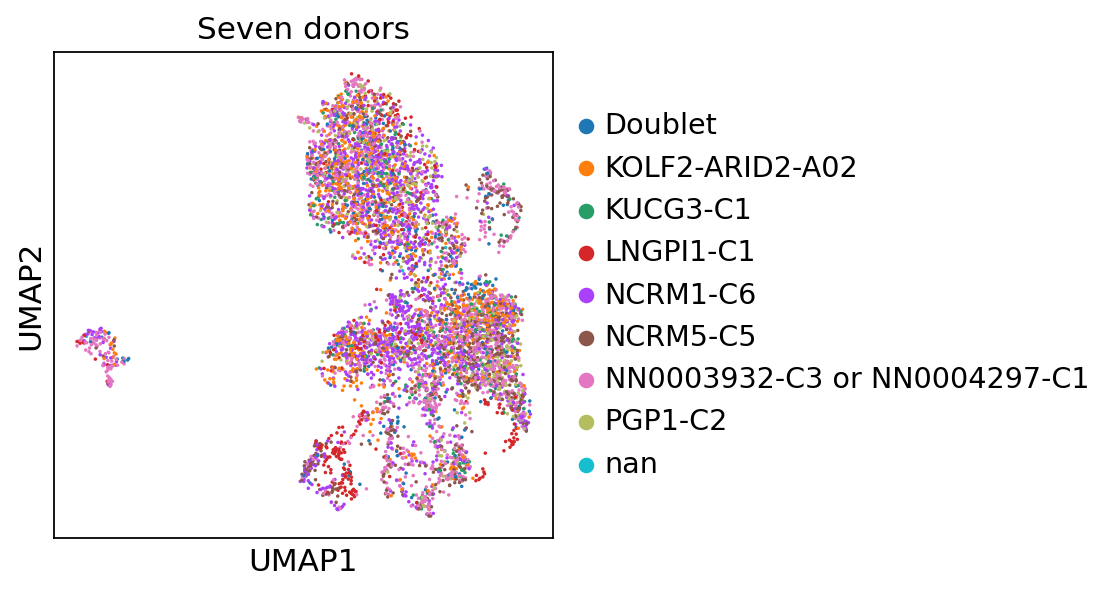

In [107]:
sc.pl.umap(adata, color=['donor_label'], title="Seven donors", size=10, save="ump_combined1_hNIL_donors.pdf")

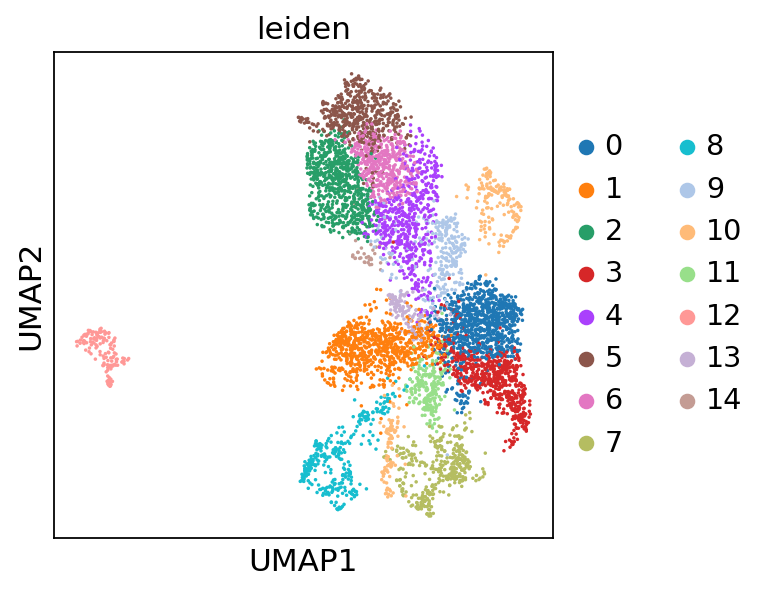

In [108]:
sc.pl.umap(adata, color=['leiden'], title="leiden", size=10, save="ump_combined1_hNIL_leiden.pdf")

In [0]:
labels = ['KOLF2-ARID2-A02',
 'KUCG3-C1',
 'NCRM1-C6',
 'NCRM5-C5',
 'PGP1-C2',
 'LNGPI1-C1',
 'NN0003932-C3 or NN0004297-C1', 'Doublet','nan']

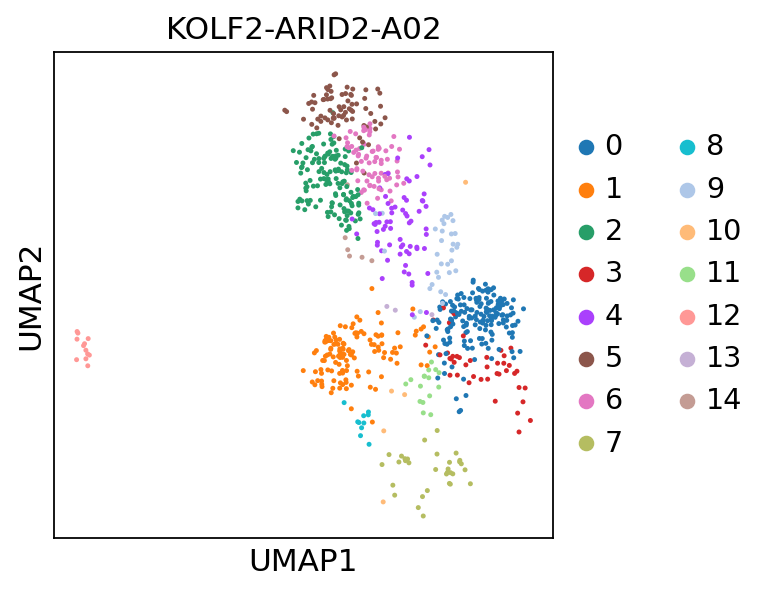

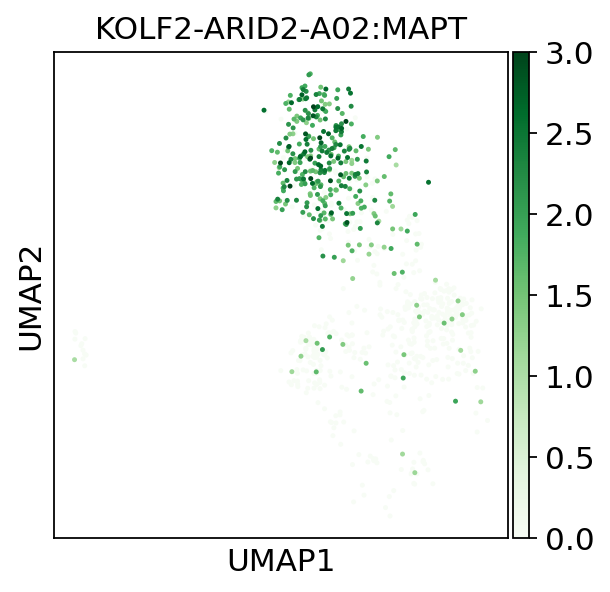

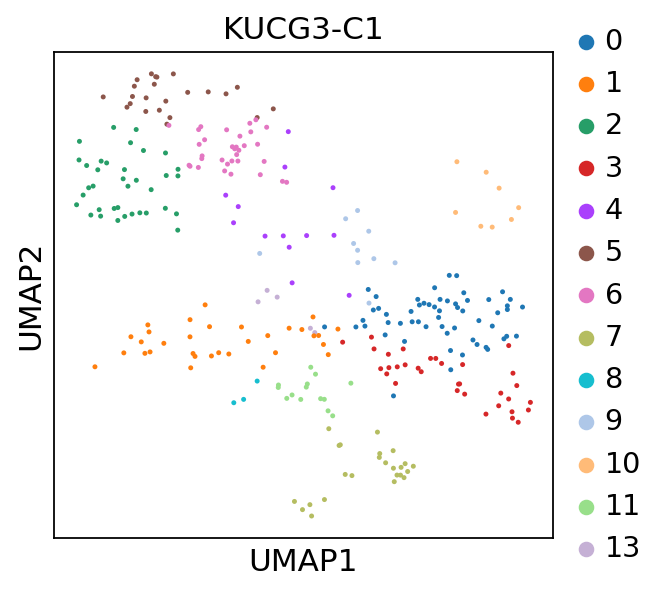

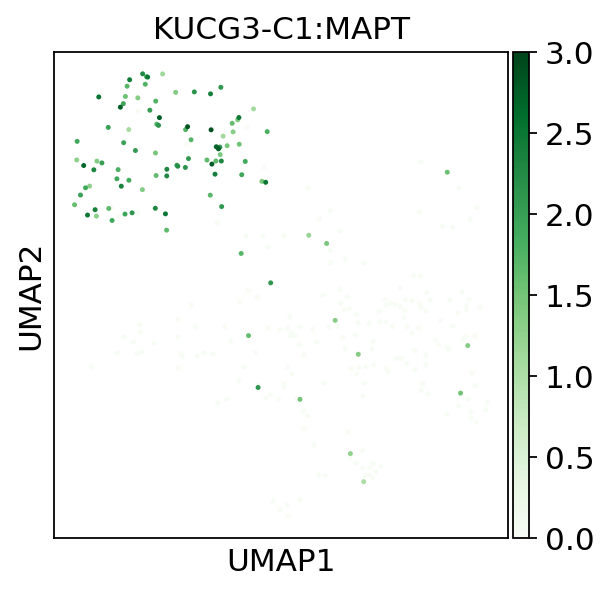

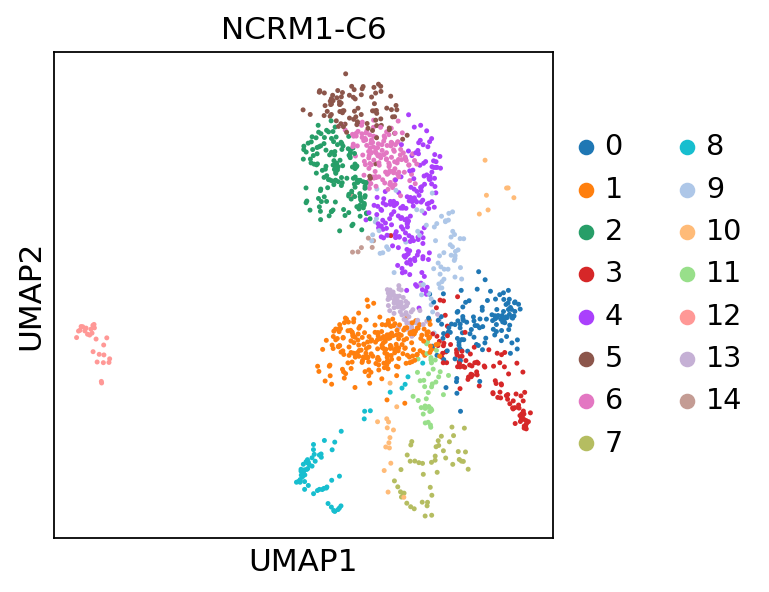

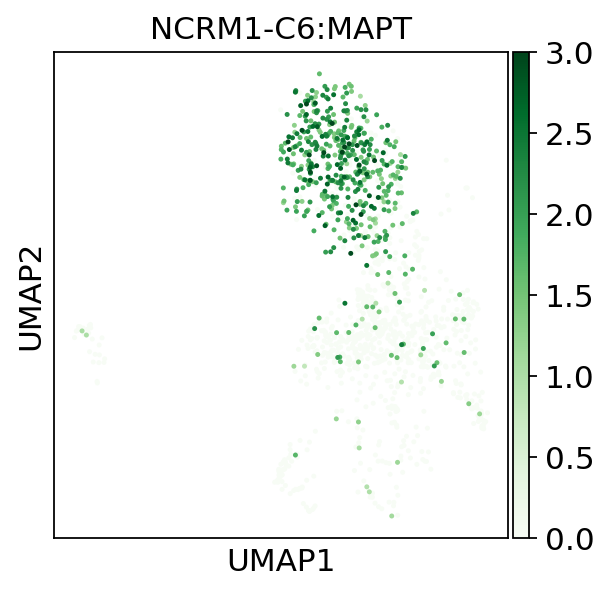

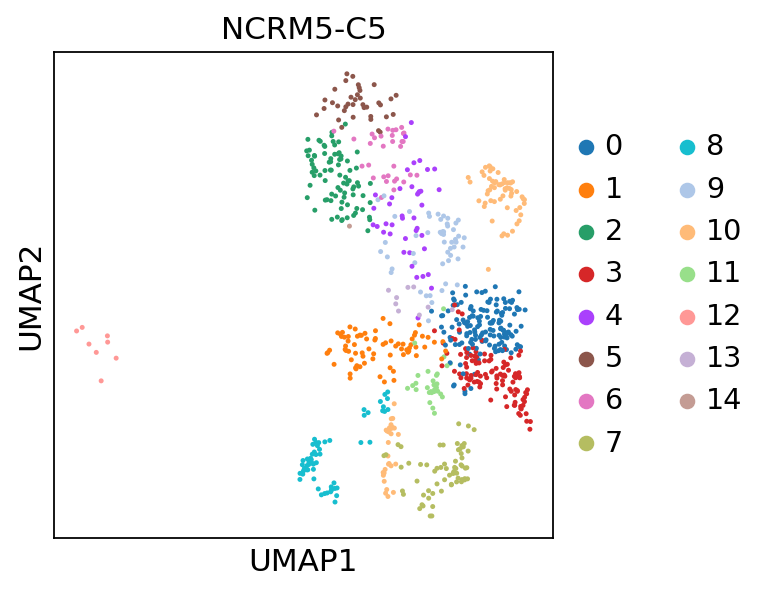

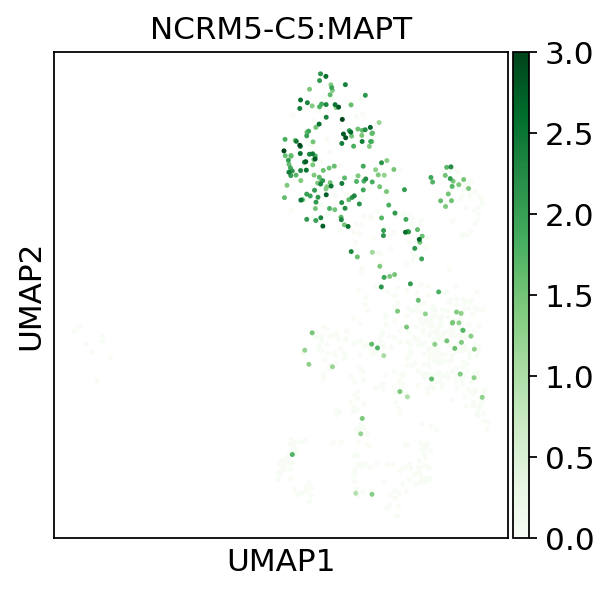

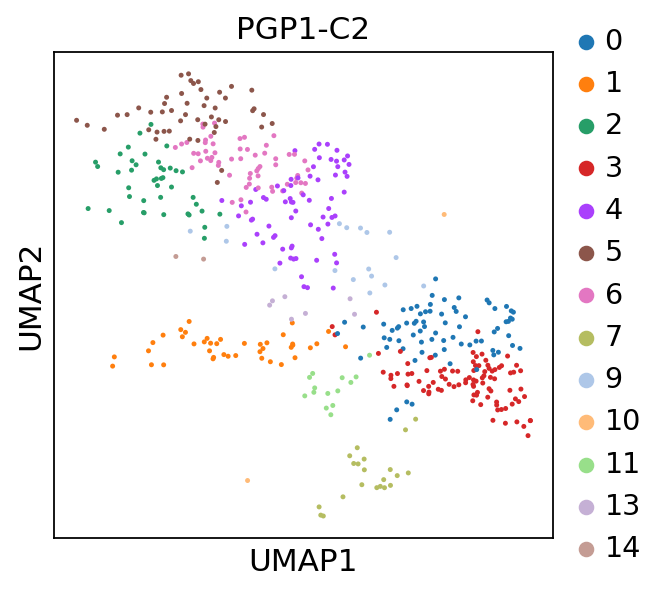

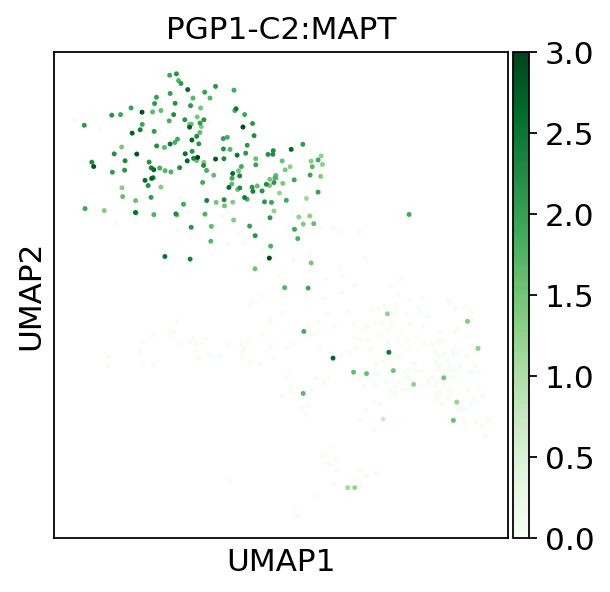

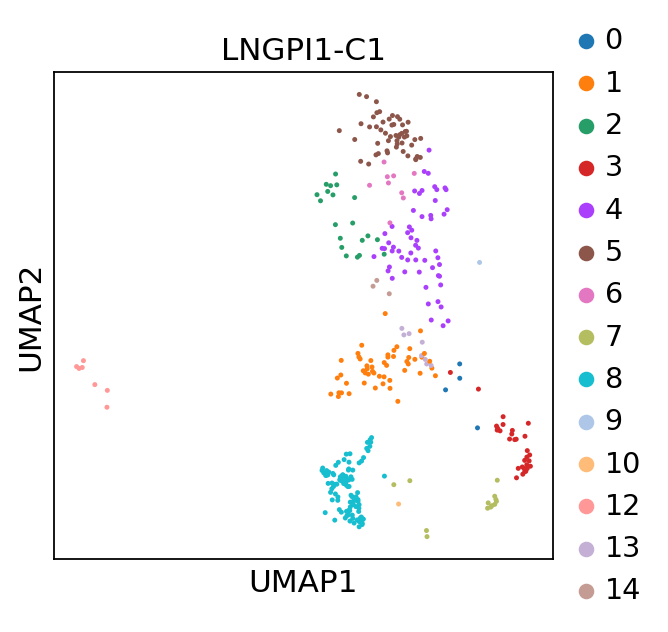

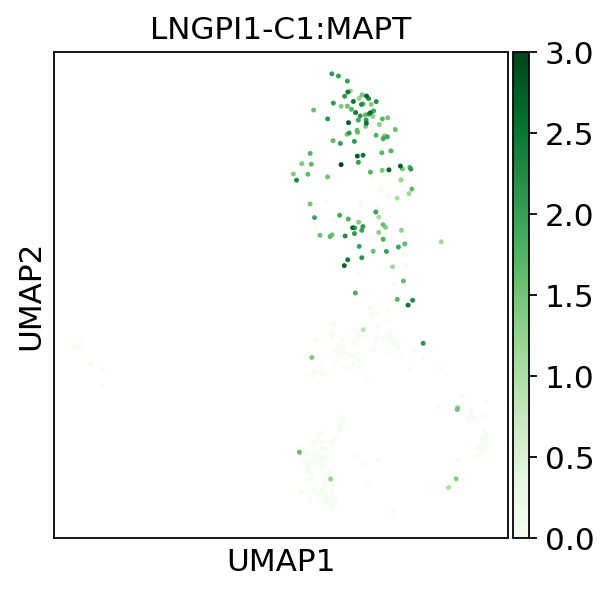

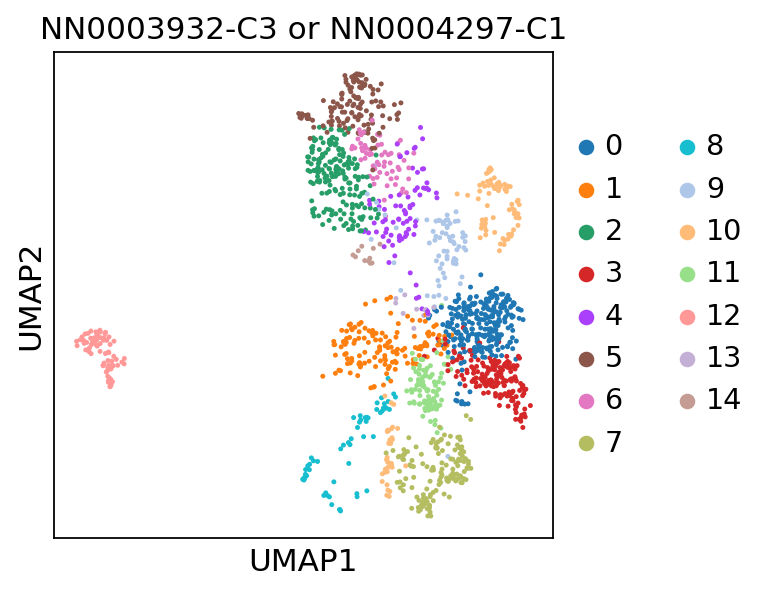

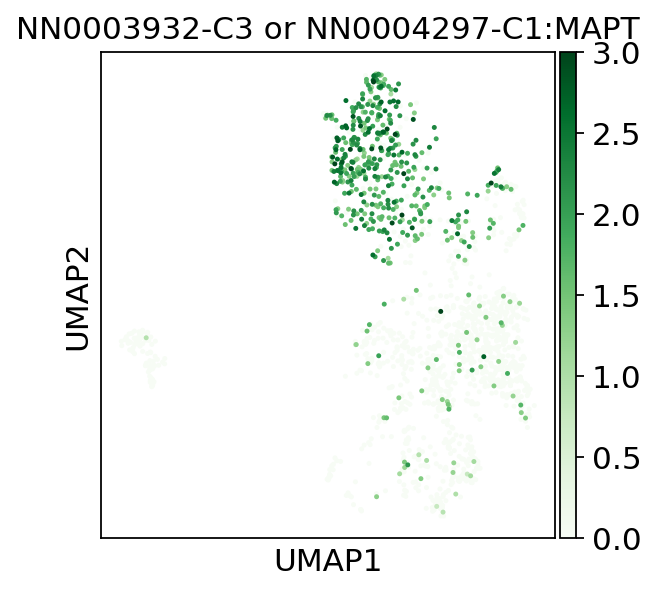

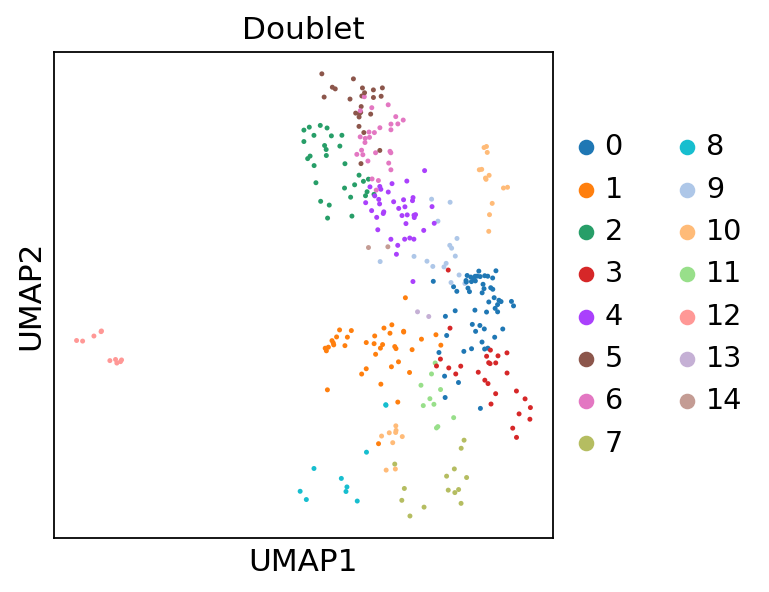

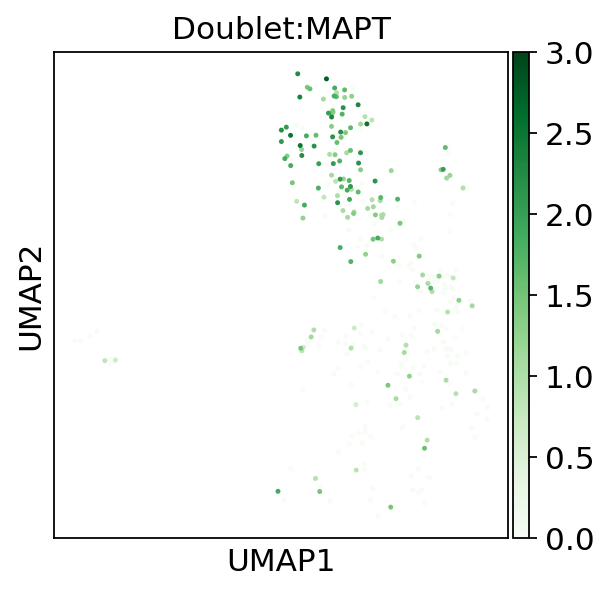

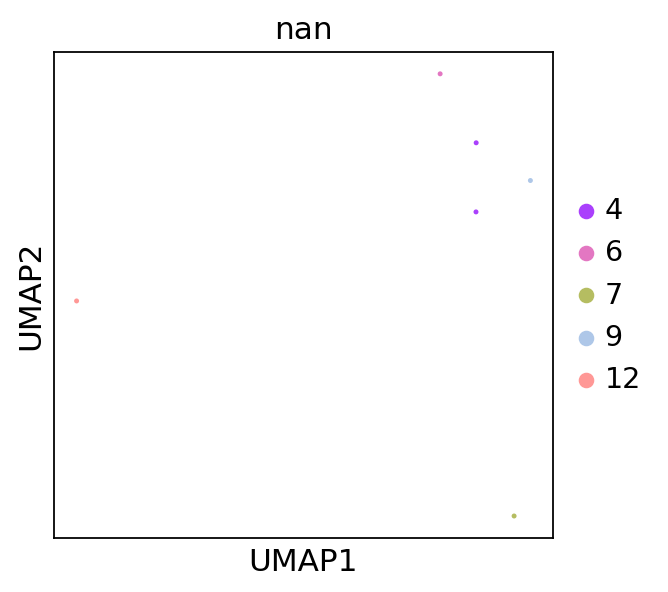

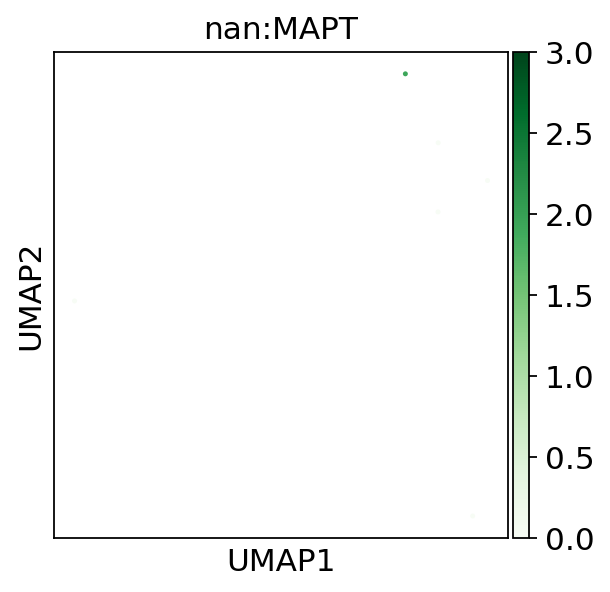

In [110]:
for i in labels:
  ax_title=i+":MAPT"
  ax = sc.pl.umap(adata[adata.obs["donor_label"] == i], color="leiden", color_map="Blues", title=i, size=20)
  sc.pl.umap(
    adata[adata.obs["donor_label"] == i],
    size=20,
    color=["MAPT"],
    color_map="Greens",
    vmax=3,
    title=ax_title,
    ax = ax
  )